In [ ]:
import tensorflow as tf
import gc
import os
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 1.2 MB/s eta 0:00:00
Mounted at /gdrive
/gdrive


In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets/Static/Left45.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets/Static/Right45.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

X_train_autoencoder=np.concatenate((X_train_left,X_train_right),axis=0)
X_test_autoencoder=np.concatenate((X_test_left,X_test_right),axis=0)
del X_train_right
del X_train_left

In [ ]:
X_train_autoencoder.shape

(408, 480, 640, 3)

In [ ]:
class CNN_Autoencoder(Model):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=X_train_autoencoder.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')])

        self.decoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(3, 3, strides=1, padding='same', activation='relu')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
with strategy.scope():
  cnn_autoencoder_right_left=CNN_Autoencoder()
  cnn_autoencoder_right_left.compile(optimizer='adam',  loss='mse')
history=cnn_autoencoder_right_left.fit(X_train_autoencoder,X_train_autoencoder,epochs=40,batch_size=16,shuffle=True,validation_data=(X_test_autoencoder,X_test_autoencoder))

Epoch 1/40
26/26 [==============================] - 33s 852ms/step - loss: 0.0603 - val_loss: 0.0118
Epoch 2/40
26/26 [==============================] - 5s 178ms/step - loss: 0.0101 - val_loss: 0.0072
Epoch 3/40
26/26 [==============================] - 5s 175ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 4/40
26/26 [==============================] - 4s 172ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/40
26/26 [==============================] - 4s 171ms/step - loss: 0.0012 - val_loss: 9.5054e-04
Epoch 6/40
26/26 [==============================] - 4s 170ms/step - loss: 8.1158e-04 - val_loss: 7.1091e-04
Epoch 7/40
26/26 [==============================] - 4s 175ms/step - loss: 6.2488e-04 - val_loss: 5.6776e-04
Epoch 8/40
26/26 [==============================] - 5s 186ms/step - loss: 5.0866e-04 - val_loss: 4.8450e-04
Epoch 9/40
26/26 [==============================] - 4s 169ms/step - loss: 4.3659e-04 - val_loss: 4.3471e-04
Epoch 10/40
26/26 [==============================] - 4s 175ms/s

In [ ]:
del X_train_autoencoder
del X_test_autoencoder

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cnn_autoencoder_right_left.save('/gdrive/My Drive/Models_Static/Right45', options=save_locally)

In [ ]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_right_left = tf.keras.models.load_model('/gdrive/My Drive/Models_Static/Right45', options=load_locally)

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered/Static/Left45.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.
y_train=load_hkl['ytrain']
y_test=load_hkl['ytest']

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered/Static/Right45.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

xm_train_left=reconstructed_right_left.encoder(X_train_left)
xm_test_left=reconstructed_right_left.encoder(X_test_left)

xm_train_right=reconstructed_right_left.encoder(X_train_right)
xm_test_right=reconstructed_right_left.encoder(X_test_right)

del X_train_left
del X_train_right
del X_test_left
del X_test_right
del reconstructed_right_left
del load_hkl

In [ ]:
xm_train_left.shape

TensorShape([194, 120, 160, 32])

In [ ]:
xm_train_right.shape

TensorShape([194, 120, 160, 32])

In [ ]:
xm_train_left=tf.reshape(xm_train_left,[xm_train_left.shape[0],-1])
xm_test_left=tf.reshape(xm_test_left,[xm_test_left.shape[0],-1])

xm_train_right=tf.reshape(xm_train_right,[xm_train_right.shape[0],-1])
xm_test_right=tf.reshape(xm_test_right,[xm_test_right.shape[0],-1])

# **Aligning Left and Right vectors and taking max**

In [ ]:
  '''

  xm_train=np.empty((0,xm_train_left.shape[1]),dtype='float32')

  xm_test=np.empty((0,xm_test_left.shape[1]),dtype='float32')


  for i in range(xm_train_left.shape[0]):

      xm_train_1=np.empty((0,xm_train_left.shape[1]),dtype='float32')

      xm_train_1=np.concatenate((xm_train_1,np.reshape(xm_train_left[i,:],(1,-1))),axis=0)
      xm_train_1=np.concatenate((xm_train_1,np.reshape(xm_train_right[i,:],(1,-1))),axis=0)

      xm_train=np.concatenate((xm_train,np.reshape(xm_train_1.max(axis=0),(1,-1))),axis=0)

  for j in range(xm_test_left.shape[0]):

      xm_test_1=np.empty((0,xm_test_left.shape[1]),dtype='float32')

      xm_test_1=np.concatenate((xm_test_1,np.reshape(xm_test_left[j,:],(1,-1))),axis=0)
      xm_test_1=np.concatenate((xm_test_1,np.reshape(xm_test_right[j,:],(1,-1))),axis=0)

      xm_test=np.concatenate((xm_test,np.reshape(xm_test_1.max(axis=0),(1,-1))),axis=0)
  '''
  xm_train=np.empty((0,xm_train_left.shape[1]*2),dtype='float32')

  xm_test=np.empty((0,xm_test_left.shape[1]*2),dtype='float32')

  for i in range(xm_train_left.shape[0]):

      xm_train_1=np.empty((0,xm_train.shape[1]),dtype='float32')

      xm_train_1=np.concatenate((np.reshape(xm_train_right[i,:],(1,-1)),np.reshape(xm_train_left[i,:],(1,-1))),axis=1)

      xm_train=np.concatenate((xm_train,np.reshape(xm_train_1,(1,-1))),axis=0)

  for j in range(xm_test_left.shape[0]):

      xm_test_1=np.empty((0,xm_test.shape[1]),dtype='float32')

      xm_test_1=np.concatenate((np.reshape(xm_test_right[j,:],(1,-1)),np.reshape(xm_test_left[j,:],(1,-1))),axis=1)

      xm_test=np.concatenate((xm_test,np.reshape(xm_test_1.max(axis=0),(1,-1))),axis=0)

  del xm_train_1
  del xm_test_1
  del xm_train_left
  del xm_train_right
  print(xm_train.shape)
  gc.collect()

(194, 1228800)


22855

## **Machine Learning**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

xm_train=scaler.fit_transform(xm_train)
xm_test=scaler.transform(xm_test)

In [ ]:
from sklearn.svm import SVC

svc=SVC(kernel="sigmoid")
svc.fit(xm_train, y_train)

SVC(kernel='sigmoid')

In [ ]:
y_pred=svc.predict(xm_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[49  4]
 [ 6 24]]
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91        53
         1.0       0.86      0.80      0.83        30

    accuracy                           0.88        83
   macro avg       0.87      0.86      0.87        83
weighted avg       0.88      0.88      0.88        83



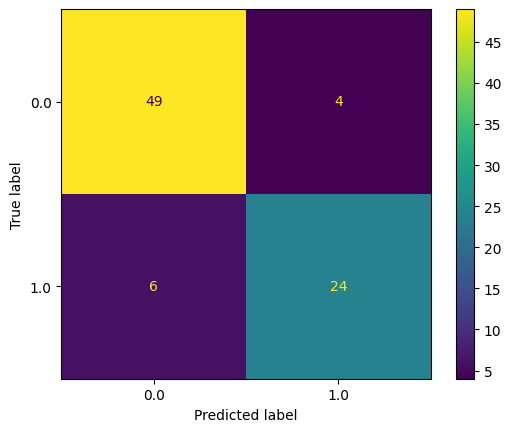

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=30, criterion="entropy", random_state=0)

rfc.fit(xm_train, y_train)
y_pred=rfc.predict(xm_test)

cm=confusion_matrix(y_test, y_pred)
print(cm)

[[51  2]
 [ 6 24]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93        53
         1.0       0.92      0.80      0.86        30

    accuracy                           0.90        83
   macro avg       0.91      0.88      0.89        83
weighted avg       0.90      0.90      0.90        83

